In [1]:
!pip install xgboost matplotlib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 56.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [55]:
import pandas as pd
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [56]:
power_data = pd.read_csv('artifacts/power_cleaned_data.csv')

bin_edges = range(0, int(power_data['Patv'].max()) + 100, 100)

# Bin the Patv column
power_data['Patv'] = pd.cut(power_data['Patv'], bins=bin_edges, labels=False, right=False)

power_data.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,53,20:00,7.96,3.38,34.93,45.50,212.74,1.00,1.00,1.00,-0.23,8
1,1,53,20:10,8.97,-1.94,34.90,45.54,207.82,1.00,1.00,1.00,-0.21,10
2,1,53,20:20,8.98,5.65,34.85,45.58,220.33,1.00,1.00,1.00,-0.20,11
3,1,53,20:30,8.12,1.19,34.52,45.49,251.20,1.00,1.00,1.00,-0.20,9
4,1,53,20:40,5.89,-1.71,34.24,45.46,249.54,0.99,0.99,0.99,-0.24,4


In [57]:
class DataCleaner:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Apply all abnormal conditions to filter out invalid data
        conditions = [
            self.data['Patv'] < 0,
            (self.data['Wspd'] < 1) & (self.data['Patv'] > 10),
            (self.data['Wspd'] < 2) & (self.data['Patv'] > 100),
            (self.data['Wspd'] < 3) & (self.data['Patv'] > 200),
            (self.data['Wspd'] > 2.5) & (self.data['Patv'] == 0),
            (self.data['Wspd'] == 0) & (self.data['Wdir'] == 0) & (self.data['Etmp'] == 0),
            self.data['Etmp'] < -21,
            self.data['Itmp'] < -21,
            self.data['Etmp'] > 60,
            self.data['Itmp'] > 70,
            (self.data['Wdir'] > 180) | (self.data['Wdir'] < -180),
            (self.data['Ndir'] > 720) | (self.data['Ndir'] < -720),
            (self.data['Pab1'] > 89) | (self.data['Pab2'] > 89) | (self.data['Pab3'] > 89)
        ]
        
        self.data['Patv'] = self.data['Patv'].astype(int)

        # Combine all conditions with OR operator
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition |= condition
        
        # Filter out rows that meet any of the abnormal conditions
        self.data = self.data[~combined_condition]

        self.data = self.data.dropna()
        return self.data

# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(power_data)
cleaned_data = cleaner.clean_data()


# Display the first few rows of the cleaned dataframe to verify the data is cleaned correctly
cleaned_data.head()

train, test = train_test_split(cleaned_data, test_size=0.5, random_state=42)
train

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
577,1,58,09:50,3.16,1.60,20.52,29.20,196.95,0.99,0.99,0.99,-0.23,1
2631,1,78,16:40,8.88,1.57,25.22,35.30,-1.60,1.00,1.00,1.00,-0.24,10
1851,1,71,19:50,2.14,-0.19,36.53,44.29,120.98,0.99,0.99,0.99,-0.25,0
2280,1,75,08:30,3.15,-1.29,27.42,36.48,31.15,0.99,0.99,0.99,-0.23,1
3103,1,82,10:50,4.23,1.02,30.59,39.32,192.70,0.99,0.99,0.99,-0.21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,1,64,21:30,10.24,-0.43,33.36,44.09,69.93,1.00,1.00,1.00,-0.26,13
1357,1,67,15:30,10.34,1.75,39.74,51.45,49.58,1.02,1.02,1.02,-0.22,12
898,1,61,12:50,1.89,-12.24,29.20,36.59,221.58,1.00,1.00,1.90,0.00,0
3751,1,89,01:00,10.52,-1.63,35.17,45.99,15.60,1.00,1.00,1.00,-0.31,14


In [58]:
# encode Tmstamp column to numeric values
train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9

/var/folders/pw/7hr2k18x7713lgrp51kl_3080000gn/T/ipykernel_32879/3317315984.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['Tmstamp'] = pd.to_datetime(train['Tmstamp']).astype(int) // 10**9
/var/folders/pw/7hr2k18x7713lgrp51kl_3080000gn/T/ipykernel_32879/3317315984.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test['Tmstamp'] = pd.to_datetime(test['Tmstamp']).astype(int) // 10**9


<Axes: >

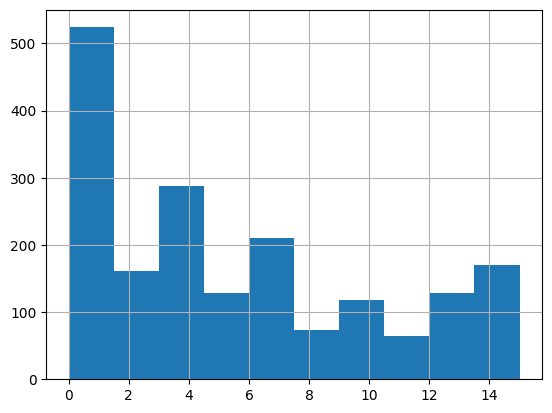

In [59]:
train["Patv"].hist()

<Axes: >

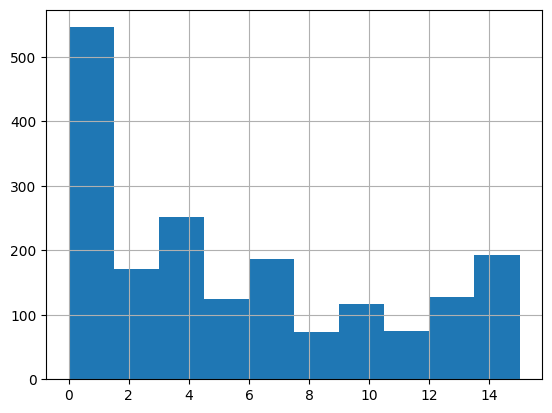

In [52]:
test["Patv"].hist()

In [61]:
X.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv'],
      dtype='object')

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split the data into training and testing sets
X = train.drop(columns=['Patv'])
y = train['Patv']

X_test = test.drop(columns=['Patv'])
y_test = test['Patv']

original_model = XGBClassifier()

original_model.fit(X, y)

y_pred = original_model.predict(X_test)

# Calculate precision, recall, and F1 score, classification report
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(classification_report(y_test, y_pred))


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       299
           1       0.88      0.94      0.90       247
           2       0.82      0.73      0.77       171
           3       0.81      0.69      0.75       127
           4       0.68      0.78      0.73       125
           5       0.72      0.69      0.70       125
           6       0.70      0.76      0.73       108
           7       0.67      0.67      0.67        79
           8       0.62      0.59      0.61        74
           9       0.62      0.60      0.61        63
          10       0.49      0.42      0.45        53
          11       0.67      0.69      0.68        75
          12       0.66      0.67      0.67        64
          13       0.67      0.67      0.67        64
          14       0.73      0.76      0.74        71
          15       0.90      0.93      0.91       121

    accuracy                           0.79      1866
   macro avg       0.73   

### GAN synthesized data

In [18]:
from synthetic_energy.time_series import DGAN, DGANConfig
# disable mps device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


features = train.to_numpy()
n_time_points = 2
n = features.shape[0] // n_time_points
features = features[: n * n_time_points, :].reshape(
    -1, n_time_points, features.shape[1]
)

config = DGANConfig(max_sequence_len=20, sample_len=5, batch_size=10, epochs=10, cuda=False)
dg = DGAN(config=config)

dg.train_numpy(
    features=features,
)

attributes, features = dg.generate_numpy(n=100)

print(features[0])

2024-12-04 20:26:22 [info     ] Training DGAN model            dtype=dtype('float64') features_length=933 first_sequence_shape=(2, 13)
2024-12-04 20:26:22 [info     ] Determining outputs metadata from input data
2024-12-04 20:26:22 [info     ] Building DGAN networks        
2024-12-04 20:26:22 [info     ] Checking for nans in the numeric columns number_of_columns=13
2024-12-04 20:26:22 [info     ] Applying linear interpolations for nans (does not mean nans are present)
2024-12-04 20:26:22 [info     ] Creating encoded array of features
2024-12-04 20:26:22 [info     ] Creating encoded array of attributes
2024-12-04 20:26:22 [info     ] Training...                    dtype=dtype('float32') internal_additional_attributes_shape=(933, 26) internal_attributes_shape=(933, 1) internal_features_shape=(933, 20, 13)
2024-12-04 20:26:22 [info     ] Creating TensorDataset        
2024-12-04 20:26:22 [info     ] Calling _train()              
2024-12-04 20:26:22 [info     ] Training                  

/Users/infraspeak/anaconda3/envs/icsp/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


2024-12-04 20:26:26 [info     ] Training                       epoch=1
2024-12-04 20:26:30 [info     ] Training                       epoch=2
2024-12-04 20:26:34 [info     ] Training                       epoch=3
2024-12-04 20:26:37 [info     ] Training                       epoch=4
2024-12-04 20:26:41 [info     ] Training                       epoch=5
2024-12-04 20:26:44 [info     ] Training                       epoch=6
2024-12-04 20:26:48 [info     ] Training                       epoch=7
2024-12-04 20:26:52 [info     ] Training                       epoch=8
2024-12-04 20:26:56 [info     ] Training                       epoch=9
[[ 1.00000000e+00  7.58870468e+01  1.73334093e+09  1.54298992e+01
   2.51078186e+01  3.72096252e+01  3.92608185e+01  1.16955475e+02
   1.00505173e+00  1.01436913e+00  1.01872480e+00 -2.92271584e-01
   7.00972939e+00]
 [ 1.00000000e+00  5.80067329e+01  1.73329011e+09  5.43595409e+00
   2.81960449e+01  2.36777592e+01  3.78377342e+01  3.28204224e+02
   9.6710062

In [19]:
import numpy as np
import pandas as pd

# Define the column names
columns = ["TurbID", "Day", "Tmstamp", "Wspd", "Wdir", "Etmp", "Itmp", "Ndir", "Pab1", "Pab2", "Pab3", "Prtv", "Patv"]

# Convert the generated list to a NumPy array
features_array = np.array(features)

# Reshape the array and convert it to a DataFrame
synthetic_df = pd.DataFrame(features_array.reshape(-1, features_array.shape[-1]), columns=columns)

synthetic_df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1.0,75.887047,1.733341e+09,15.429899,25.107819,37.209625,39.260818,116.955475,1.005052,1.014369,1.018725,-0.292272,7.009729
1,1.0,58.006733,1.733290e+09,5.435954,28.196045,23.677759,37.837734,328.204224,0.967101,0.980136,0.993289,-0.296205,3.441965
2,1.0,57.956074,1.733290e+09,4.967329,25.066589,23.274683,37.808189,119.342346,0.956955,0.974426,0.982715,-0.296258,3.278841
3,1.0,57.923000,1.733291e+09,4.792045,25.037338,23.320168,37.803902,118.491760,0.958199,0.974009,0.982336,-0.296229,3.274817
4,1.0,57.783195,1.733290e+09,4.988285,25.033997,23.306526,37.805294,120.759766,0.956826,0.974692,0.982813,-0.296261,3.273627
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.0,61.153412,1.733295e+09,6.282700,20.617264,24.208151,37.764763,164.665100,0.967962,0.982672,0.990732,-0.292745,2.798287
1996,1.0,61.196327,1.733295e+09,6.246295,20.595673,24.211693,37.767052,167.258850,0.967874,0.982677,0.990752,-0.292717,2.781207
1997,1.0,61.146477,1.733295e+09,6.230822,20.594040,24.195374,37.763241,164.658630,0.967870,0.982680,0.990733,-0.292745,2.773533
1998,1.0,61.149055,1.733295e+09,6.229264,20.594025,24.194838,37.762897,164.650574,0.967941,0.982672,0.990732,-0.292745,2.773382


<Axes: >

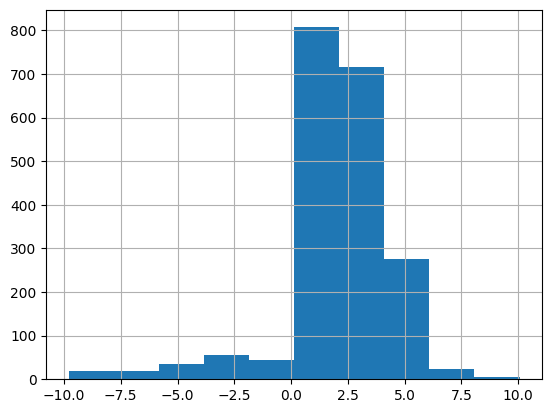

In [21]:
synthetic_df["Patv"].hist()

<Axes: >

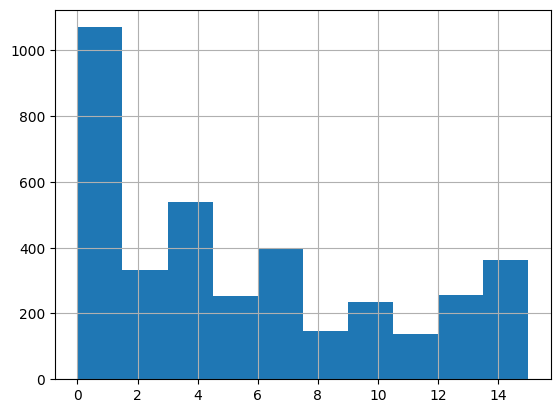

In [22]:
cleaned_data["Patv"].hist()

In [23]:
# Create an instance of the DataCleaner class and clean the data
cleaner = DataCleaner(synthetic_df)
synthesized_cleaned_data = cleaner.clean_data()
# Assuming synthesized_cleaned_data is your DataFrame
synthesized_cleaned_data = synthesized_cleaned_data.astype(float)
synthesized_cleaned_data['Tmstamp'] = pd.to_datetime(synthesized_cleaned_data['Tmstamp']).astype(int) // 10**9

In [24]:
# Split the data into training and testing sets
X_synth_train, X_synth_test = train_test_split(synthesized_cleaned_data, test_size=0.5, random_state=42)

y_synth_train = X_synth_train['Patv']
X_synth_train = X_synth_train.drop(columns=['Patv'])

y_synth_test = X_synth_test['Patv']
X_synth_test = X_synth_test.drop(columns=['Patv'])


# Train an XGBoost model 
synthetic_model = XGBClassifier()
synthetic_model.fit(X_synth_train, y_synth_train)

# Make predictions on the test set
y_pred_synth = synthetic_model.predict(X_synth_test)

# Calculate precision, recall, and F1 score, classification report
precision_synth = precision_score(y_synth_test, y_pred_synth, average='weighted')
recall_synth = recall_score(y_synth_test, y_pred_synth, average='weighted')
f1_synth = f1_score(y_synth_test, y_pred_synth, average='weighted')

print(classification_report(y_synth_test, y_pred_synth))

print(f'Precision: {precision_synth}')
print(f'Recall: {recall_synth}')
print(f'F1 Score: {f1_synth}')

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       160
         1.0       0.96      0.98      0.97       241
         2.0       0.95      0.94      0.95       196
         3.0       0.95      0.92      0.93       145
         4.0       0.91      0.89      0.90        92
         5.0       0.89      0.87      0.88        63
         6.0       0.33      0.27      0.30        11
         7.0       0.00      0.00      0.00         1
         8.0       0.50      0.50      0.50         2
         9.0       0.00      0.00      0.00         1

    accuracy                           0.94       912
   macro avg       0.64      0.64      0.64       912
weighted avg       0.93      0.94      0.93       912

Precision: 0.9347588318897948
Recall: 0.9353070175438597
F1 Score: 0.9348672461754771


/Users/infraspeak/anaconda3/envs/icsp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/infraspeak/anaconda3/envs/icsp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/infraspeak/anaconda3/envs/icsp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

In [26]:
from synthetic_energy.quality_metrics import (
    WassersteinDistance,
    KLDivergence,
    PopulationStabilityIndex
)




# Calculate the Wasserstein distance between the original and synthetic data
wd = WassersteinDistance()
wd_value = wd(train, synthetic_df)
print(f'Wasserstein Distance: {wd_value}')

# Calculate the Kullback-Leibler divergence between the original and synthetic data
kl = KLDivergence()
kl_value = kl(train, synthetic_df)
print(f'KL Divergence: {kl_value}')

# Calculate the Population Stability Index between the original and synthetic data
psi = PopulationStabilityIndex()
psi_value = psi(train, synthetic_df)
print(f'Population Stability Index: {psi_value}')


2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=TurbID dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Day dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Tmstamp dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Wspd dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Wdir dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Etmp dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Itmp dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Ndir dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Pab1 dtype=dtype('float32')
2024-12-04 20:28:17 [warning  ] Unsupported data type for column column=Pab2 dtype=dtype('float3

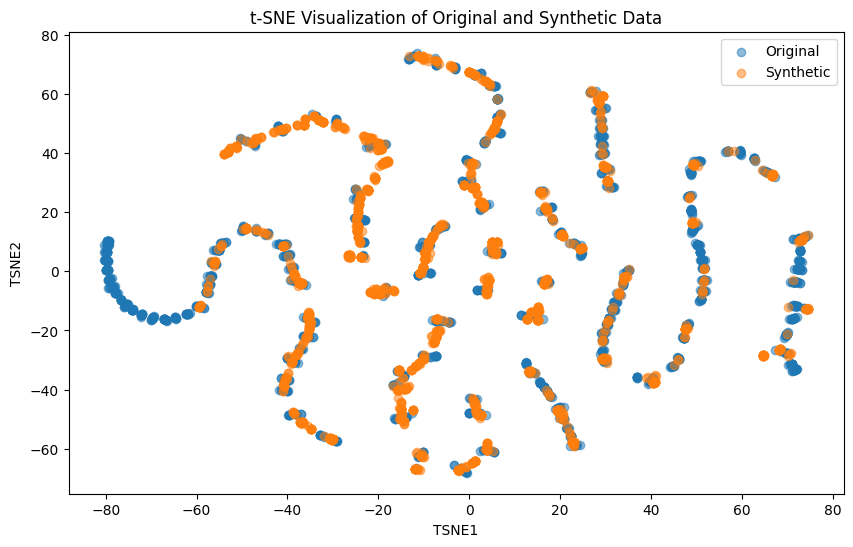

In [35]:
from sklearn.manifold import TSNE

# Combine the original and synthetic data for t-SNE visualization
combined_data = np.vstack((train.values, synthetic_df.values))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_data)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = ['Original'] * len(train) + ['Synthetic'] * len(synthetic_df)

# Plot the results
plt.figure(figsize=(10, 6))
for label in tsne_df['label'].unique():
    subset = tsne_df[tsne_df['label'] == label]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], label=label, alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Original and Synthetic Data')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

## Membership Inference Attack

In [90]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# train dataframe was used to train the classifier and test wasnt used. 
# Now the attack model is trained with samples from both train and test labeled as 1 and 0 respectively (0 being the training data)

# Label the data
train['label'] = 1
test['label'] = 0


# Combine the data
attack_data = pd.concat([train, test])

# shuffle the data
attack_data = attack_data.sample(frac=1, random_state=42)

# Split the data into features and labels
X_attack = attack_data.drop(columns=['label'])
y_attack = attack_data['label']

attack_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,label
1261,1,65,1733303400,7.40,1.11,31.71,42.24,31.44,1.00,1.00,1.00,-0.18,7,0
587,1,58,1733311800,4.35,-1.46,22.74,31.22,217.69,0.99,0.99,0.99,-0.29,2,0
1774,1,71,1733291400,6.55,0.83,28.06,38.49,412.97,1.00,1.00,1.00,-0.27,5,1
3654,1,88,1733293800,4.01,1.54,30.72,38.84,417.27,0.99,0.99,0.99,-0.25,1,1
1192,1,64,1733348400,9.70,-1.33,33.08,44.29,69.93,1.00,1.00,1.00,-0.23,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3802,1,89,1733304600,8.93,3.18,35.20,47.25,43.93,1.00,1.00,1.00,-0.25,11,1
2400,1,76,1733304600,11.59,-2.33,31.33,42.34,-298.45,1.03,1.03,1.03,-0.25,14,1
2325,1,75,1733346000,2.93,-0.54,36.37,43.79,-265.04,0.99,0.99,0.99,-0.25,1,1
2138,1,74,1733301000,10.71,1.80,29.59,41.89,50.33,1.02,1.02,1.02,-0.29,14,0


In [75]:
original_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [91]:
# Pass through regressor model to get the predictions
attack_data['Patv'] = original_model.predict(X_attack.drop(columns=['Patv']))
attack_data_classes = attack_data.copy()
attack_data_classes

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,label
1261,1,65,1733303400,7.40,1.11,31.71,42.24,31.44,1.00,1.00,1.00,-0.18,7,0
587,1,58,1733311800,4.35,-1.46,22.74,31.22,217.69,0.99,0.99,0.99,-0.29,2,0
1774,1,71,1733291400,6.55,0.83,28.06,38.49,412.97,1.00,1.00,1.00,-0.27,5,1
3654,1,88,1733293800,4.01,1.54,30.72,38.84,417.27,0.99,0.99,0.99,-0.25,1,1
1192,1,64,1733348400,9.70,-1.33,33.08,44.29,69.93,1.00,1.00,1.00,-0.23,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3802,1,89,1733304600,8.93,3.18,35.20,47.25,43.93,1.00,1.00,1.00,-0.25,11,1
2400,1,76,1733304600,11.59,-2.33,31.33,42.34,-298.45,1.03,1.03,1.03,-0.25,14,1
2325,1,75,1733346000,2.93,-0.54,36.37,43.79,-265.04,0.99,0.99,0.99,-0.25,1,1
2138,1,74,1733301000,10.71,1.80,29.59,41.89,50.33,1.02,1.02,1.02,-0.29,14,0


In [92]:
# Get the predicted probabilities on X_attack
X_attack = attack_data.drop(columns=['Patv'])
y_pred_proba = original_model.predict_proba(X_attack.drop(columns=['label']))

# Create separate columns for each class's probability
for i in range(y_pred_proba.shape[1]):
    attack_data[f'Patv_class_{i}_proba'] = y_pred_proba[:, i]

attack_data.drop(columns=['Patv'], inplace=True)
attack_data_prob = attack_data.copy()
attack_data_prob

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,...,Patv_class_6_proba,Patv_class_7_proba,Patv_class_8_proba,Patv_class_9_proba,Patv_class_10_proba,Patv_class_11_proba,Patv_class_12_proba,Patv_class_13_proba,Patv_class_14_proba,Patv_class_15_proba
1261,1,65,1733303400,7.40,1.11,31.71,42.24,31.44,1.00,1.00,...,0.001490,0.872961,0.125218,0.000019,0.000030,0.000029,0.000043,0.000024,0.000034,0.000019
587,1,58,1733311800,4.35,-1.46,22.74,31.22,217.69,0.99,0.99,...,0.000208,0.000113,0.000164,0.000064,0.000378,0.000061,0.000154,0.000130,0.000210,0.000038
1774,1,71,1733291400,6.55,0.83,28.06,38.49,412.97,1.00,1.00,...,0.005535,0.000026,0.000044,0.000029,0.000128,0.000069,0.000033,0.000086,0.000042,0.000052
3654,1,88,1733293800,4.01,1.54,30.72,38.84,417.27,0.99,0.99,...,0.000035,0.000030,0.000034,0.000084,0.000051,0.000055,0.000014,0.000039,0.000019,0.000034
1192,1,64,1733348400,9.70,-1.33,33.08,44.29,69.93,1.00,1.00,...,0.000117,0.000055,0.000140,0.000121,0.000256,0.003900,0.983727,0.009070,0.001804,0.000064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3802,1,89,1733304600,8.93,3.18,35.20,47.25,43.93,1.00,1.00,...,0.000022,0.000030,0.000070,0.000217,0.011577,0.987320,0.000234,0.000022,0.000047,0.000055
2400,1,76,1733304600,11.59,-2.33,31.33,42.34,-298.45,1.03,1.03,...,0.000064,0.000091,0.000320,0.000136,0.000205,0.000291,0.000368,0.001230,0.969679,0.027094
2325,1,75,1733346000,2.93,-0.54,36.37,43.79,-265.04,0.99,0.99,...,0.000024,0.000007,0.000008,0.000010,0.000009,0.000006,0.000006,0.000008,0.000006,0.000008
2138,1,74,1733301000,10.71,1.80,29.59,41.89,50.33,1.02,1.02,...,0.000748,0.000791,0.001554,0.001398,0.000470,0.007672,0.004044,0.008574,0.971784,0.000729


In [80]:
y_pred_proba.shape

(3732, 16)

In [93]:
import torch
import torch.nn as nn


class AttackerModel(nn.Module):
    def __init__(self, input_dim):
        super(AttackerModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
    

# Define the model
attacker_model = AttackerModel(input_dim=attack_data_prob.shape[1])

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(attacker_model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(attack_data_prob.values, dtype=torch.float32).view(-1, attack_data_prob.shape[1])
y_tensor = torch.tensor(y_attack.values, dtype=torch.float32).view(-1, 1)


In [94]:

# Train the model
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = attacker_model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Get the predictions from the model
predictions = attacker_model(X_tensor).detach().numpy()
predictions = (predictions > 0.5).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_attack, predictions)
print(f'Accuracy: {accuracy}')



Epoch 1, Loss: 50.0
Epoch 2, Loss: 50.0
Epoch 3, Loss: 50.0
Epoch 4, Loss: 50.0
Epoch 5, Loss: 50.0
Epoch 6, Loss: 50.0
Epoch 7, Loss: 50.0
Epoch 8, Loss: 50.0
Epoch 9, Loss: 50.0
Epoch 10, Loss: 50.0
Epoch 11, Loss: 50.0
Epoch 12, Loss: 50.0
Epoch 13, Loss: 50.0
Epoch 14, Loss: 50.0
Epoch 15, Loss: 50.0
Epoch 16, Loss: 50.0
Epoch 17, Loss: 50.0
Epoch 18, Loss: 50.0
Epoch 19, Loss: 50.0
Epoch 20, Loss: 50.0
Epoch 21, Loss: 50.0
Epoch 22, Loss: 50.0
Epoch 23, Loss: 50.0
Epoch 24, Loss: 50.0
Epoch 25, Loss: 50.0
Epoch 26, Loss: 50.0
Epoch 27, Loss: 50.0
Epoch 28, Loss: 50.0
Epoch 29, Loss: 50.0
Epoch 30, Loss: 50.0
Epoch 31, Loss: 50.0
Epoch 32, Loss: 50.0
Epoch 33, Loss: 50.0
Epoch 34, Loss: 50.0
Epoch 35, Loss: 50.0
Epoch 36, Loss: 50.0
Epoch 37, Loss: 50.0
Epoch 38, Loss: 50.0
Epoch 39, Loss: 50.0
Epoch 40, Loss: 50.0
Epoch 41, Loss: 50.0
Epoch 42, Loss: 50.0
Epoch 43, Loss: 50.0
Epoch 44, Loss: 50.0
Epoch 45, Loss: 50.0
Epoch 46, Loss: 50.0
Epoch 47, Loss: 50.0
Epoch 48, Loss: 50.0
E